# Playground Series - Season 4, Episode 1 - Binary Classification with a Bank Churn Dataset

In [27]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import optuna
from datetime import datetime as dt
from sklearn import set_config

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

#notebook settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
set_config(display='diagram')

#category encoders
from category_encoders import BinaryEncoder


#sklearn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, Binarizer, LabelEncoder, OneHotEncoder, TargetEncoder, LabelEncoder, OrdinalEncoder
# metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc, accuracy_score
# imbalanced datasets
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import TomekLinks,RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, SelectKBest
# model selection
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
# pipelines
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.utils import class_weight

#calibration
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve

## READING FILES

**Bank Customer Churn Dataset**

The Bank Customer Churn Dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be customers. The dataset includes the following attributes:
- Customer ID: A unique identifier for each customer.
- Surname: The customer's surname or last name.
- Credit Score: A numerical value representing the customer's credit score.
- Geography: The country where the customer resides (France, Spain, or Germany).
- Gender: The customer's gender (Male or Female).
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank.
- Balance: The customer's account balance.
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card).
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no).
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no).
- EstimatedSalary: The estimated salary of the customer.
- Exited: Whether the customer has churned (1 = yes, 0 = no).

In [28]:
train_df = pd.read_csv('data/train.csv', index_col='id')
test_df = pd.read_csv('data/test.csv',index_col='id')
submission = pd.read_csv('data/sample_submission.csv')

## 1) EDA - Exploratory Data Analysis

### 1.1) Checking for missing values

In [29]:
train_df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [30]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [31]:
test_df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [32]:
test_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


No missing Values in train and test data 😃✅

### 1.2) Checking for duplicated values

In [33]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


No duplicated Values in train and test data 😃✅

### 1.3) Size of train and test data

In [34]:
print(train_df.shape)
print(test_df.shape)

(165034, 13)
(110023, 12)


### 1.4) Uniques values

In [35]:
# let's start looking at the training data
train_df.nunique()

CustomerId         23221
Surname             2797
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

### 1.5) data type information

In [36]:
train_df.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64


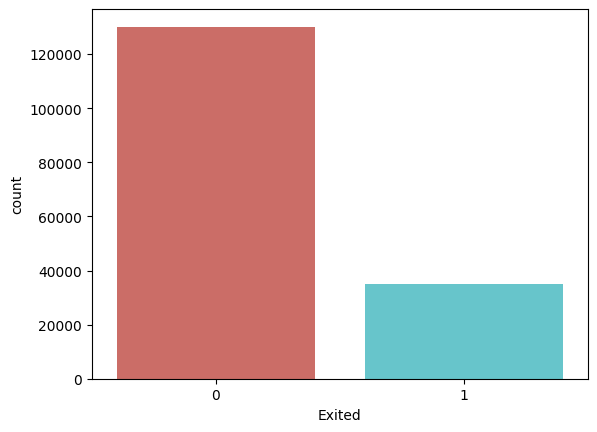

In [37]:
# let's look at the target variable
print(train_df['Exited'].value_counts(normalize=True))


# let's look at the distribution of the target variable
sns.countplot(x='Exited', data=train_df, palette='hls'); #imbalanced dataset

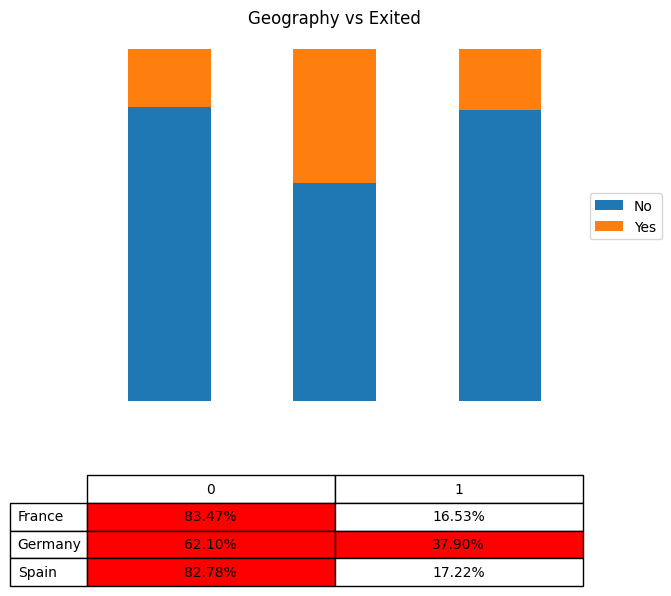

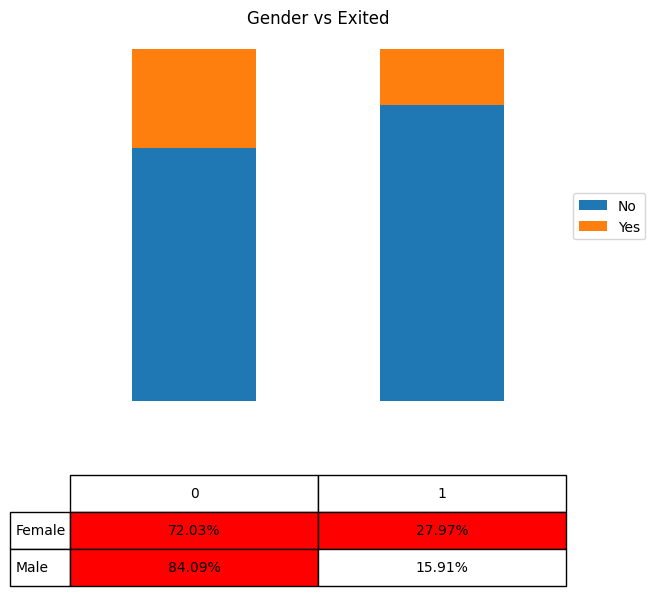

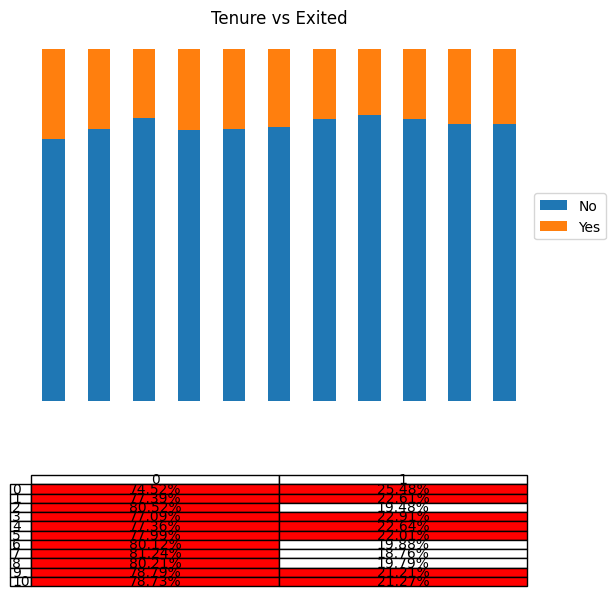

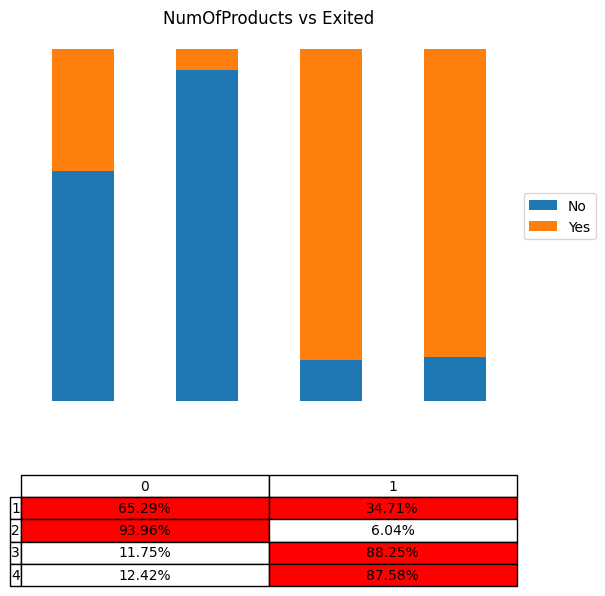

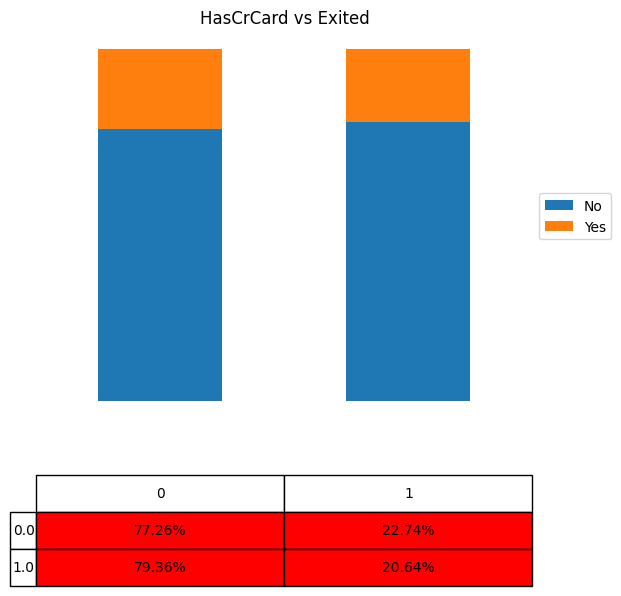

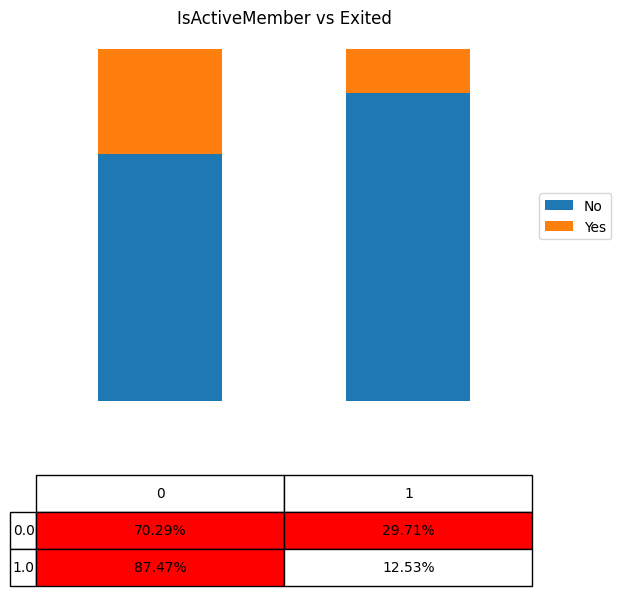

In [38]:
# checking proportions or target variable for categorical and numerical variables with unique values less than 15

def check_proportions(df, col, threshold=0.2):
    proportions = df.groupby(col)['Exited'].value_counts(normalize=True).unstack()
    proportions.plot(kind='bar', stacked=True)
    
    # Move the legend to the side of the bars
    plt.legend(['No','Yes'],loc='center left', bbox_to_anchor=(1, 0.5))
    
    # add title
    plt.title(f'{col} vs Exited')
    
    # Create a table below the graph
    table_data = []
    cell_colors = []
    for i in range(len(proportions)):
        row_data = []
        row_colors = []
        for j in range(len(proportions.columns)):
            value = proportions.iloc[i, j]
            if value > threshold:
                row_data.append(f'{value:.2%}')
                row_colors.append('red')  # Highlight imbalanced values with red color
            else:
                row_data.append(f'{value:.2%}')
                row_colors.append('white')
        table_data.append(row_data)
        cell_colors.append(row_colors)
    
    table = plt.table(cellText=table_data,
                      colLabels=proportions.columns,
                      rowLabels=proportions.index,
                      loc='bottom',
                      cellLoc='center',
                      bbox=[0, -0.5, 1, 0.3],  # Increase the height by modifying the bbox parameter
                      cellColours=cell_colors)  # Set cell colors
    
    # Hide the axes and axis labels
    plt.axis('off')
    
    plt.show()

# selecting columns with unique values less than 15
cols = train_df.columns[train_df.nunique() < 15].tolist()
cols.remove('Exited')

# apply to all variables and plot the proportions
for col in cols:    
    check_proportions(train_df, col)


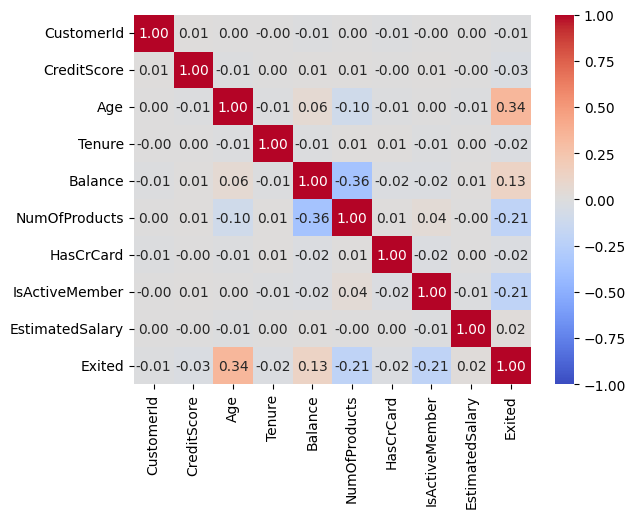

In [39]:
correlation_matrix = train_df.select_dtypes(exclude='object').corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix.round(2), 
            xticklabels=column_names, 
            yticklabels=column_names,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f");


Possible issues due to correlations:

- Exited possible issues: 
  - Age
  - Balance
  - NumOfProducts
  - IsActiveMember

- between features:
  - Balance vs NumOfProducts
  - Age vs NumOfProducts

Feature Binning:

For continuous variables like "Age" or "Balance," consider binning or discretizing them into categories. 
This can help capture non-linear relationships and reduce sensitivity to outliers.

In [40]:
train_df.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [42]:
print(train_df['NumOfProducts'].dtype)

int64


## 2) PreProcess Data

In [68]:
class CreateSurnameFeatures(TransformerMixin):
    """Create new features based on the 'Surname' column."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['Surname_Length'] = data['Surname'].apply(len)
        data['Surname_Frequency'] = data['Surname'].map(data['Surname'].value_counts())
        data['Surname_Ratio_Frequency_Length'] = data['Surname_Frequency'] / data['Surname_Length']
        return data
    
    def get_feature_names_out(self, input_features=None):
        return input_features + ['Surname_Length', 'Surname_Frequency', 'Surname_Ratio_Frequency_Length']

class Binner(TransformerMixin):
    """Bin a numerical feature."""
    def __init__(self, feature, num_bins, binning_method=pd.qcut):
        self.feature = feature
        self.num_bins = num_bins
        self.binning_method = binning_method

    def transform(self, X):
        data = X.copy()
        bins = self.binning_method(data[self.feature], q=self.num_bins, labels=False, precision=0)
        data[f'{self.feature}_Bins'] = bins.astype('object')
        return data
    
    def get_feature_names_out(self, input_features=None):
        return input_features + [f'{self.feature}_Bins']

class BalanceToSalaryRatio(TransformerMixin):
    """Create balance-to-salary ratio feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['BalanceToSalaryRatio'] = data['Balance'] / data['EstimatedSalary']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['BalanceToSalaryRatio']
    
class NumOfProductsHasCrCardInteraction(TransformerMixin):
    """Create interaction feature between 'NumOfProducts' and 'HasCrCard'."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['NumOfProductsHasCrCardInteraction'] = data['NumOfProducts'] * data['HasCrCard']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['NumOfProductsHasCrCardInteraction']
    
class TenureToAgeRatio(TransformerMixin):
    """Create tenure-to-age ratio feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['TenureToAgeRatio'] = data['Tenure'] / data['Age']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['TenureToAgeRatio']
    
class LoyaltyScore(TransformerMixin):
    """Create loyalty score feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['LoyaltyScore'] = data['IsActiveMember'] * data['Tenure']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['LoyaltyScore']


feature_creation_pipeline = Pipeline(steps=[
    ('balance_to_salary_ratio', BalanceToSalaryRatio()),
    ('num_of_products_has_cr_card_interaction', NumOfProductsHasCrCardInteraction()),
    ('tenure_to_age_ratio', TenureToAgeRatio()),
    ('loyalty_score', LoyaltyScore()),
    ('fix_surname', CreateSurnameFeatures()),
    ('bin_credit_score', Binner(feature='CreditScore', num_bins=4)),
    ('bin_age', Binner(feature='Age', num_bins=4)),
])

# all columns except the target variable
cols = train_df.columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('feature_creation', feature_creation_pipeline, cols),
    ('pass', 'passthrough', ['HasCrCard', 'IsActiveMember'])
], remainder='passthrough')


# Fit and transform the pipeline on your training data
transformed_data = preprocessor.fit_transform(train_df)

# Get the feature names after transformation
feature_names_out = feature_creation_pipeline.get_feature_names_out()

# Display the transformed data and feature names
print(transformed_data)
print("Feature names after transformation:", feature_names_out)

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '<__main__.Binner object at 0x0000023EC77E3310>' (type <class '__main__.Binner'>) doesn't

In [64]:
# Fit and transform the pipeline on your training data
transformed_data = feature_creation_pipeline.fit_transform(train_df)

# Get the feature names after transformation
feature_names_out = feature_creation_pipeline.get_feature_names_out()

# Display the transformed data and feature names
print(transformed_data)
print("Feature names after transformation:", feature_names_out)

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '<__main__.Binner object at 0x0000023EC5977670>' (type <class '__main__.Binner'>) doesn't

In [195]:
# Additional scaling and encoding pipeline
scaling_encoding_pipeline = FeatureUnion(transformer_list=[
    ('numeric_pipeline', Pipeline(steps=[
        ('robust_scaler', RobustScaler()),
    ])),
    ('categorical_pipeline', Pipeline(steps=[
        ('onehot_encoder', OneHotEncoder(drop='first')),
    ])),
])

# Final pipeline after feature engineering
final_pipeline = Pipeline(steps=[
    ('feature_creation', feature_creation_pipeline),
    ('scaling_encoding', scaling_encoding_pipeline),
])

final_pipeline


Pipeline(steps=[('feature_creation',
                 Pipeline(steps=[('column_selector',
                                  ColumnSelector(columns=['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'Surname', 'HasCrCard', 'NumOfProducts', 'IsActiveMember'])),
                                 ('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('balance_to_salary_ratio',
                                                                                    <__main__.BalanceT...
                                                                                    <__main__.Binner object at 0x00000210F2C696F0>)]),
                                                                   ['Surname',
                                                                    'HasCrCard',
                                                                    'NumOfProducts',
                                                                    'IsActiveMember']),
                                                                  ('pass',
                                                                   'passthrough',
                                                                   ['HasCrCard',
                                                                    'IsActiveMember'])]))])),
                ('scaling_encoding',
                 FeatureUnion(transformer_list=[('numeric_pipeline',
                                                 Pipeline(steps=[('robust_scaler',
                                                                  RobustScaler())])),
                                                ('categorical_pipeline',
                                                 Pipeline(steps=[('onehot_encoder',
                                                                  OneHotEncoder(drop='first'))]))]))])

In [196]:
final_pipeline.steps

[('feature_creation',
  Pipeline(steps=[('column_selector',
                   ColumnSelector(columns=['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'Surname', 'HasCrCard', 'NumOfProducts', 'IsActiveMember'])),
                  ('preprocessor',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('num',
                                                    Pipeline(steps=[('balance_to_salary_ratio',
                                                                     <__main__.BalanceToSalaryRatio object at 0x00000210F2C69B...
                                                     'Balance', 'EstimatedSalary',
                                                     'Tenure']),
                                                   ('cat',
                                                    Pipeline(steps=[('fix_surname',
                                                                     <__main__.CreateSurnameFeatures

In [189]:
# let's test the pipeline on the training data
X_train = final_pipeline.fit_transform(train_df)
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

# create a dataframe with the transformed data and feature names
X_transformed = pd.DataFrame(X_train, columns=feature_names)

print('X_transformed shape: {}'.format(X_transformed.shape))
print('y shape: {}'.format(train_df['Exited'].shape))

# check dataframe head
X_transformed.head()

KeyError: 'NumOfProducts'

In [147]:
# use xgboost as the model for our pipeline
params = {
    'objective': 'binary:logistic',
    'n_jobs': -1,
    'eval_metric': 'roc_auc'
}
    
model = xgb.XGBClassifier(params=params)
    

# let's create a pipeline with our previous pipeline (preprocessor) and the model
xgb_pipe = Pipeline(steps=[
    ('preprocessor', pipeline),
    ('xgboost', model)
])

# let's train our model
xgb_pipe.fit(train_df, train_df['Exited'])

# let's make predictions on the test set
predictions = xgb_pipe.predict_proba(test_df)[:, 1]

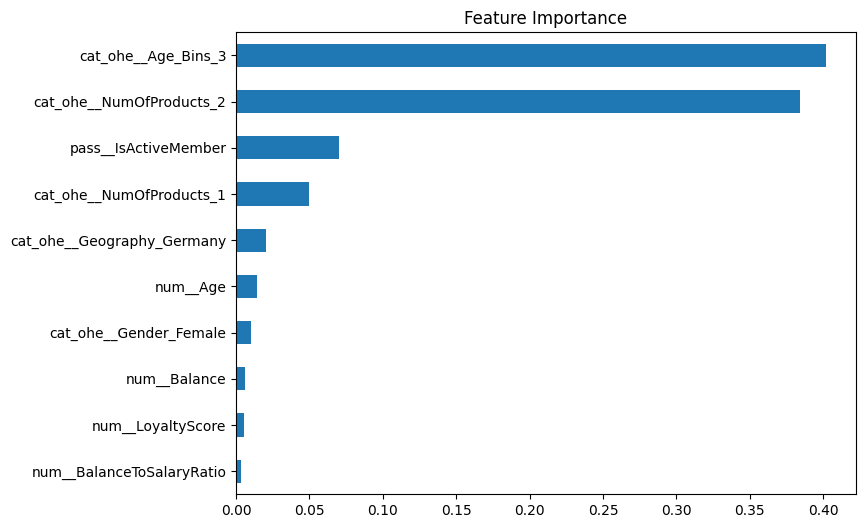

In [148]:
# let's create a function to plot the feature importance
def plot_feature_importance(model, X, y, top_n=10):
    plt.figure(figsize=(8, 6))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(top_n).sort_values(ascending=True).plot(kind='barh')
    plt.title('Feature Importance')
    plt.show()

# Use the function to plot feature importance
plot_feature_importance(xgb_pipe.named_steps['xgboost'], X_transformed, train_df['Exited'])

In [123]:
# create a dataframe of feature importance values sorted by importance
feature_importance = pd.DataFrame({'feature': X_transformed.columns, 'importance': xgb_pipe.named_steps['xgboost'].feature_importances_}).sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
12,cat_ohe__Age_Bins_3,0.402227
6,cat_ohe__NumOfProducts_2,0.384471
30,pass__IsActiveMember,0.070243
5,cat_ohe__NumOfProducts_1,0.049617
1,cat_ohe__Geography_Germany,0.020548
18,num__Age,0.014505
3,cat_ohe__Gender_Female,0.010324
20,num__Balance,0.006365
28,num__LoyaltyScore,0.005168
25,num__BalanceToSalaryRatio,0.003197


['cat_ohe__Age_Bins_3',
 'cat_ohe__NumOfProducts_2',
 'pass__IsActiveMember',
 'cat_ohe__NumOfProducts_1',
 'cat_ohe__Geography_Germany',
 'num__Age',
 'cat_ohe__Gender_Female',
 'num__Balance',
 'num__LoyaltyScore',
 'num__BalanceToSalaryRatio']

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('fix_surname', CreateSurnameFeatures()),
                                 ('bin_credit_score',
                                  Binner(feature='CreditScore', num_bins=4)),
                                 ('bin_age', Binner(feature='Age', num_bins=4)),
                                 ('balance_to_salary_ratio',
                                  BalanceToSalaryRatio()),
                                 ('num_of_products_has_cr_card_interaction',
                                  NumOfProductsHasCrCardInteraction()),
                                 ('tenure_to_age_ratio', T...
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               params={'eval_metric': 'roc_auc', 'n_jobs': -1,
                                       'objective': 'binary:logistic'}, ...))])

In [128]:


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


def objective(trial):
    params = {
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 100.0),
    }

    model = xgb.XGBClassifier(**params)
    
    #use pipeline
    xgb_pipe = Pipeline(steps=[
        ('preprocessor', pipeline),
        ('xgboost', model)
    ])
    
    #fit model
    xgb_pipe.fit(X_train, y_train)
    
    #roc auc score
    predictions = xgb_pipe.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, predictions)
    
    return roc_auc

KeyError: "None of [Index(['Age_Bins_3', 'NumOfProducts_2', 'pass__IsActiveMember',\n       'NumOfProducts_1', 'Geography_Germany', 'num__Age', 'Gender_Female',\n       'num__Balance', 'num__LoyaltyScore', 'num__BalanceToSalaryRatio'],\n      dtype='object')] are in the [columns]"

In [125]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-11 21:51:43,917] A new study created in memory with name: no-name-0980d5d4-3936-4ad8-bd67-5e6e0446090d
[W 2024-01-11 21:51:43,929] Trial 0 failed with parameters: {'n_estimators': 914, 'learning_rate': 0.01969998402398225, 'max_depth': 2, 'subsample': 0.6195587534562479, 'colsample_bytree': 0.7912731725409581, 'min_child_weight': 7, 'gamma': 0.46307350284943016, 'scale_pos_weight': 49.161280707968665} because of the following error: IndexError('only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices').
Traceback (most recent call last):
  File "c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10856\3999097523.py", line 35, in objective
    xgb_pipe.fit(X_train, y_train)
  File "c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [37]:
params = trial.params

model_opt = xgb.XGBClassifier(**params)
    
# let's create a pipeline with our previous pipeline (preprocessor) and the model
xgb_opt = Pipeline(steps=[
    ('preprocessor', pipeline),
    ('xgboost', model_opt)
])

# let's train our model
xgb_opt.fit(train_df, train_df['Exited'])

# let's make predictions on the test set
predictions_optimized = xgb_opt.predict_proba(test_df)[:, 1]

In [38]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(estimator=xgb_pipe, 
                         X=train_df, 
                         y=train_df['Exited'], 
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1,
                         verbose=1)


scores_opt = cross_val_score(estimator=xgb_opt, 
                         X=train_df, 
                         y=train_df['Exited'], 
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1,
                         verbose=1)

# print scores and scores_opt
print('ROC AUC scores for the 10 folds: ', scores)
print('Mean ROC AUC score: %.3f' % scores.mean())

print('ROC AUC scores for the 10 folds: ', scores_opt)
print('Mean ROC AUC score: %.3f' % scores_opt.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


ROC AUC scores for the 10 folds:  [0.88256353 0.87811673 0.88290915 0.88026973 0.87996413 0.88789176
 0.88024529 0.8826954  0.88106234 0.87611885]
Mean ROC AUC score: 0.881
ROC AUC scores for the 10 folds:  [0.89166546 0.88615504 0.89049623 0.88816452 0.88613865 0.89476065
 0.8885252  0.89206629 0.88793766 0.88603869]
Mean ROC AUC score: 0.889


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.5s finished


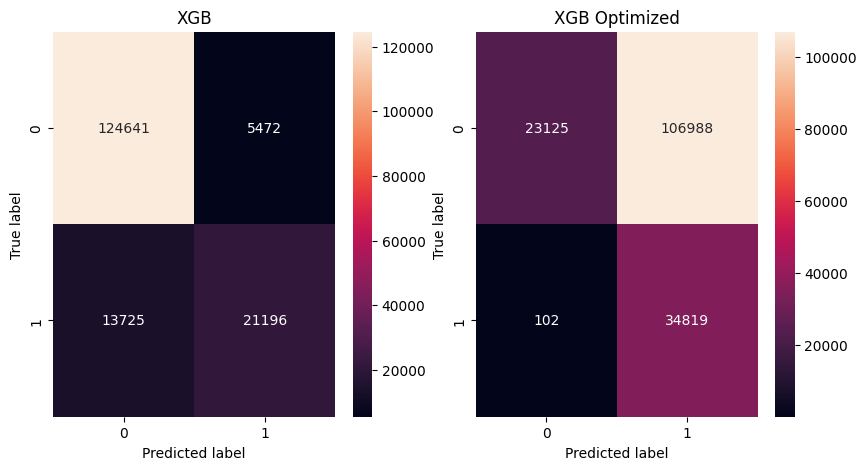

In [39]:
# plot confusion matrix for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(confusion_matrix(train_df['Exited'], xgb_pipe.predict(train_df)), annot=True, fmt='d', ax=ax1)
sns.heatmap(confusion_matrix(train_df['Exited'], xgb_opt.predict(train_df)), annot=True, fmt='d', ax=ax2)
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
plt.show()

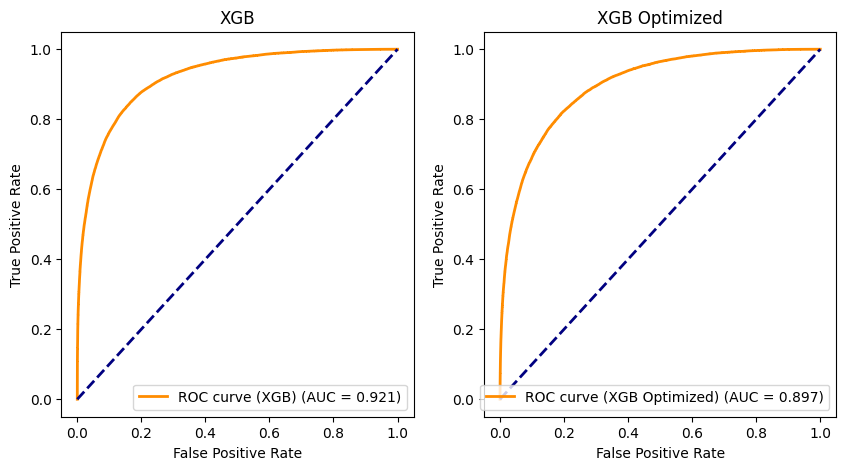

In [40]:
# plot roc curve for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fpr_xgb, tpr_xgb, _ = roc_curve(train_df['Exited'], xgb_pipe.predict_proba(train_df)[:, 1])
fpr_xgb_opt, tpr_xgb_opt, _ = roc_curve(train_df['Exited'], xgb_opt.predict_proba(train_df)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_xgb_opt = auc(fpr_xgb_opt, tpr_xgb_opt)
ax1.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (XGB) (AUC = %0.3f)' % roc_auc_xgb)
ax2.plot(fpr_xgb_opt, tpr_xgb_opt, color='darkorange', lw=2, label='ROC curve (XGB Optimized) (AUC = %0.3f)' % roc_auc_xgb_opt)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")
ax2.legend(loc="lower right")
plt.show()


[learning_curve] Training set sizes: [  1485  17823  34161  50500  66838  83176  99515 115853 132191 148530]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.9s finished


[learning_curve] Training set sizes: [  1485  17823  34161  50500  66838  83176  99515 115853 132191 148530]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished


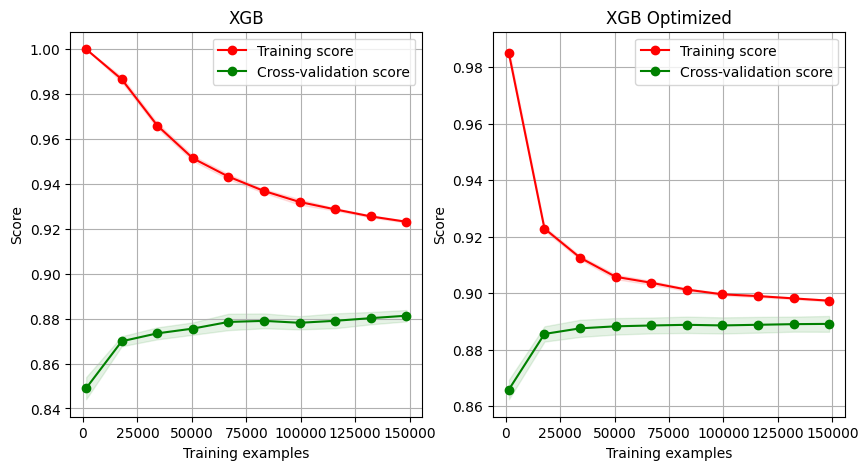

In [41]:
# plot learning curve for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
train_sizes, train_scores, test_scores = learning_curve(xgb_pipe, train_df, train_df['Exited'], cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10), verbose=1)
train_sizes_opt, train_scores_opt, test_scores_opt = learning_curve(xgb_opt, train_df, train_df['Exited'], cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10), verbose=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean_opt = np.mean(train_scores_opt, axis=1)
train_scores_std = np.std(train_scores, axis=1)
train_scores_std_opt = np.std(train_scores_opt, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean_opt = np.mean(test_scores_opt, axis=1)
test_scores_std = np.std(test_scores, axis=1)
test_scores_std_opt = np.std(test_scores_opt, axis=1)
ax1.grid()
ax2.grid()
ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
ax2.fill_between(train_sizes_opt, train_scores_mean_opt - train_scores_std_opt, train_scores_mean_opt + train_scores_std_opt, alpha=0.1, color='r')
ax2.fill_between(train_sizes_opt, test_scores_mean_opt - test_scores_std_opt, test_scores_mean_opt + test_scores_std_opt, alpha=0.1, color='g')
ax1.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
ax1.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
ax2.plot(train_sizes_opt, train_scores_mean_opt, 'o-', color='r', label='Training score')
ax2.plot(train_sizes_opt, test_scores_mean_opt, 'o-', color='g', label='Cross-validation score')
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_xlabel('Training examples')
ax1.set_ylabel('Score')
ax2.set_xlabel('Training examples')
ax2.set_ylabel('Score')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.show()

## 3) Submission

In [42]:
# add to submission dataframe
submission['Exited'] = predictions_optimized

# save to csv
submission.to_csv('data/submission_12.csv', index=False)

# Best value for my model was: 0.88634 - submission 11